# Setup
Comment out javascript if jupyter widgets not installed

In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
from pathlib import Path
from dataset import Video

# Create dataset
Creating data for input to the model is a little tricky. Details in the readme.

In [4]:
v_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/train') #in jpg format, from included script
a_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/labels.json') # in json format, from included script

In [5]:
from dataset_import import get_training_set, get_validation_set, get_test_set
from model import generate_model
class Args:
    dataset = 'kinetics'
    video_path = v_path
    annotation_path = a_path
    
input_args=Args()

In [6]:
from spatial_transforms2 import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from temporal_transforms2 import LoopPadding, TemporalRandomCrop
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose

In [7]:
norm_value=255 #for rgb data

scale_step=0.84089 #for the kinetics dataset
scales = [1]
n_scales=5
for i in range(1, n_scales):
    scales.append(scales[-1] * scale_step)
    
sample_size=112 # default for kinetics
sample_duration=4 # my choosen window size
norm_method = Normalize([110.636/norm_value, 103.1606/norm_value, 96.29/norm_value], 
                        [38.756/norm_value, 37.8824/norm_value, 40.03/norm_value]) #per the averages of the dataset
crop_method = MultiScaleRandomCrop(scales, sample_size)
spatial_transform = Compose([
            crop_method,
            RandomHorizontalFlip(),
            ToTensor(norm_value), norm_method])

In [8]:
temporal_transform = TemporalRandomCrop(sample_duration)
target_transform = ClassLabel()

In [9]:
training_data = get_training_set(input_args, spatial_transform,
                                 temporal_transform, target_transform)

dataset loading [0/73]


In [10]:
batch_size=16 #32 was too large!
n_threads=4
train_loader = torch.utils.data.DataLoader(
            training_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=n_threads,
            pin_memory=True)

# Validation Set
I have one video for training, another for test, and another for validation. Using the ActivityNet data crawler, these videos are easily transformed into the appropriate format as described in the readme.

In [11]:
v_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/val')
a_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/labels.json')

class Args:
    dataset = 'kinetics'
    video_path = v_path
    annotation_path = a_path
    n_val_samples=5
    sample_duration=4
    
val_args=Args()

In [12]:
validation_data = get_validation_set(
    val_args, spatial_transform, temporal_transform, target_transform)

dataset loading [0/26]


In [13]:
val_loader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

# Load Pre-Trained Model
### First, import kinetics pretrained model exactly as is

In [14]:
from models import resnet, pre_act_resnet, wide_resnet, resnext, densenet
import torch.nn as nn

model = resnext.resnet101(
    sample_size=112, #height and width of inputs
    sample_duration=4, #temporal, 16!!!
    num_classes=400) 

In [15]:
#from opts import parse_opts
from model import generate_model
class Args:
    sample_size = 112
    sample_duration = 4 #16!!!
    n_classes = 400
    mode='feature'
    model_name='resnext'
    model_depth=101
    resnet_shortcut='B'
    resnext_cardinality=32
    no_cuda=False
    batch_size=16
    n_threads=4

opt=Args()
model=generate_model(opt)

pretrain_path=Path('/media/tris/tris_files/github/csce_courses/video-classification-3d-cnn-pytorch/resnext-101-kinetics.pth')
model_data = torch.load(pretrain_path)
model.load_state_dict(model_data['state_dict'])
model.eval()

DataParallel(
  (module): ResNeXt(
    (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNeXtBottleneck(
        (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
        (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### With the model correcly imported, add a final layer to reduce the output size to my three desired outputs

In [16]:
for param in model.parameters():
    param.requires_grad = False
#     # Replace the last fully-connected layer
#     # Parameters of newly constructed modules have requires_grad=True by default
# model.fc = nn.Sequential(
#     nn.Linear(400, 256), #256 is arbitrary
#     nn.ReLU(),
#     nn.Linear(256,3),
#     nn.LogSoftmax(dim=1))
# model.fc.requires_grad=True
# model.cuda()
# model.eval()


In [17]:
my_module = nn.Sequential(
    nn.Linear(2048, 1200), #256 is arbitrary
    nn.ReLU(),
    nn.Linear(1200,256),
    nn.ReLU(),
    nn.Linear(256,3))
    #nn.Softmax(dim=1))#dim consider putting the softmax back in, unsure of dimension

In [18]:
my_model = nn.Sequential(model, my_module) #combining the pre-trained and new model
my_model.cuda() #put it on the gpu
my_model.eval()

Sequential(
  (0): DataParallel(
    (module): ResNeXt(
      (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): ResNeXtBottleneck(
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
          (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine

### We now have the original model, plus a few extra layers to resize the output

In [19]:
from torch import optim# Loss and optimizer
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss()
criterion=criterion.cuda()

dampening=0 #0.9
optimizer = optim.SGD(
            my_model.parameters(),
            lr=3e-3,
            momentum=0.9,
            dampening=dampening,
            weight_decay=1e-3, #1e-3 #how important is this if I'm only training the last few layers? Set to 0?
            nesterov=False)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience=10)
# Definatley need some tuning here
    

In [20]:
from utils import Logger
import os
results_path=Path('/media/tris/tris_files/github/csce_courses/')

train_logger = Logger(os.path.join(results_path, 'train.log'),
                      ['epoch', 'loss', 'acc', 'lr'])
train_batch_logger = Logger(os.path.join(results_path, 'train_batch.log'),
                            ['epoch', 'batch', 'iter', 'loss', 'acc', 'lr'])
val_logger = Logger(
            os.path.join(results_path, 'val.log'), ['epoch', 'loss', 'acc'])

In [21]:
begin_epoch=1
n_epoch=150
from train2 import train_epoch
from validation import val_epoch

for i in range(begin_epoch, n_epoch + 1):
    train_epoch(i, train_loader, my_model, criterion, optimizer, opt,
                    train_logger, train_batch_logger)
    validation_loss = val_epoch(i, val_loader, my_model, criterion, opt,
                                    val_logger)
    scheduler.step(validation_loss)

train at epoch 1
Epoch: [1][1/5]	Time 0.633 (0.633)	Data 0.341 (0.341)	Loss 1.0964 (1.0964)	Acc 0.250 (0.250)
Epoch: [1][2/5]	Time 0.026 (0.330)	Data 0.002 (0.172)	Loss 1.1118 (1.1041)	Acc 0.125 (0.188)
Epoch: [1][3/5]	Time 0.083 (0.248)	Data 0.060 (0.134)	Loss 1.0908 (1.0997)	Acc 0.438 (0.271)
Epoch: [1][4/5]	Time 0.083 (0.206)	Data 0.059 (0.116)	Loss 1.0809 (1.0950)	Acc 0.312 (0.281)
Epoch: [1][5/5]	Time 0.087 (0.183)	Data 0.064 (0.105)	Loss 1.0503 (1.0895)	Acc 0.778 (0.342)
validation at epoch 1
Epoch: [1][1/9]	Time 0.383 (0.383)	Data 0.359 (0.359)	Loss 1.0460 (1.0460)	Acc 0.938 (0.938)
Epoch: [1][2/9]	Time 0.070 (0.227)	Data 0.049 (0.204)	Loss 1.0745 (1.0602)	Acc 0.438 (0.688)
Epoch: [1][3/9]	Time 0.076 (0.177)	Data 0.052 (0.153)	Loss 1.0782 (1.0662)	Acc 0.688 (0.688)
Epoch: [1][4/9]	Time 0.074 (0.151)	Data 0.052 (0.128)	Loss 1.0536 (1.0631)	Acc 0.688 (0.688)
Epoch: [1][5/9]	Time 0.072 (0.135)	Data 0.052 (0.113)	Loss 1.0732 (1.0651)	Acc 0.688 (0.688)
Epoch: [1][6/9]	Time 0.073 (0.1

Epoch: [7][4/5]	Time 0.078 (0.154)	Data 0.054 (0.129)	Loss 1.0868 (0.8339)	Acc 0.562 (0.688)
Epoch: [7][5/5]	Time 0.079 (0.139)	Data 0.056 (0.115)	Loss 1.0368 (0.8589)	Acc 0.556 (0.671)
validation at epoch 7
Epoch: [7][1/9]	Time 0.293 (0.293)	Data 0.267 (0.267)	Loss 0.4847 (0.4847)	Acc 0.938 (0.938)
Epoch: [7][2/9]	Time 0.074 (0.183)	Data 0.048 (0.158)	Loss 1.2295 (0.8571)	Acc 0.438 (0.688)
Epoch: [7][3/9]	Time 0.073 (0.147)	Data 0.048 (0.121)	Loss 0.8257 (0.8466)	Acc 0.688 (0.688)
Epoch: [7][4/9]	Time 0.069 (0.127)	Data 0.049 (0.103)	Loss 0.9034 (0.8608)	Acc 0.688 (0.688)
Epoch: [7][5/9]	Time 0.074 (0.117)	Data 0.053 (0.093)	Loss 0.8459 (0.8578)	Acc 0.688 (0.688)
Epoch: [7][6/9]	Time 0.071 (0.109)	Data 0.052 (0.086)	Loss 0.3845 (0.7790)	Acc 1.000 (0.740)
Epoch: [7][7/9]	Time 0.073 (0.104)	Data 0.054 (0.082)	Loss 0.5579 (0.7474)	Acc 0.875 (0.759)
Epoch: [7][8/9]	Time 0.074 (0.100)	Data 0.055 (0.078)	Loss 1.1463 (0.7973)	Acc 0.500 (0.727)
Epoch: [7][9/9]	Time 0.073 (0.097)	Data 0.055 (0

Epoch: [13][1/9]	Time 0.301 (0.301)	Data 0.277 (0.277)	Loss 0.5025 (0.5025)	Acc 0.938 (0.938)
Epoch: [13][2/9]	Time 0.072 (0.187)	Data 0.049 (0.163)	Loss 1.1818 (0.8421)	Acc 0.438 (0.688)
Epoch: [13][3/9]	Time 0.073 (0.149)	Data 0.051 (0.126)	Loss 0.8083 (0.8309)	Acc 0.688 (0.688)
Epoch: [13][4/9]	Time 0.073 (0.130)	Data 0.052 (0.107)	Loss 0.8437 (0.8341)	Acc 0.688 (0.688)
Epoch: [13][5/9]	Time 0.073 (0.118)	Data 0.053 (0.096)	Loss 0.8433 (0.8359)	Acc 0.688 (0.688)
Epoch: [13][6/9]	Time 0.079 (0.112)	Data 0.059 (0.090)	Loss 0.3827 (0.7604)	Acc 1.000 (0.740)
Epoch: [13][7/9]	Time 0.077 (0.107)	Data 0.058 (0.086)	Loss 0.5374 (0.7285)	Acc 0.875 (0.759)
Epoch: [13][8/9]	Time 0.076 (0.103)	Data 0.056 (0.082)	Loss 1.0896 (0.7737)	Acc 0.500 (0.727)
Epoch: [13][9/9]	Time 0.075 (0.100)	Data 0.057 (0.079)	Loss 0.3798 (0.7676)	Acc 1.000 (0.731)
train at epoch 14
Epoch: [14][1/5]	Time 0.407 (0.407)	Data 0.379 (0.379)	Loss 0.8832 (0.8832)	Acc 0.562 (0.562)
Epoch: [14][2/5]	Time 0.075 (0.241)	Data 0

Epoch: [19][4/9]	Time 0.080 (0.148)	Data 0.059 (0.124)	Loss 0.7358 (0.7290)	Acc 0.688 (0.688)
Epoch: [19][5/9]	Time 0.087 (0.136)	Data 0.067 (0.113)	Loss 0.7975 (0.7427)	Acc 0.688 (0.688)
Epoch: [19][6/9]	Time 0.079 (0.126)	Data 0.059 (0.104)	Loss 0.3365 (0.6750)	Acc 1.000 (0.740)
Epoch: [19][7/9]	Time 0.080 (0.120)	Data 0.060 (0.098)	Loss 0.5653 (0.6593)	Acc 0.875 (0.759)
Epoch: [19][8/9]	Time 0.075 (0.114)	Data 0.055 (0.092)	Loss 1.0819 (0.7121)	Acc 0.500 (0.727)
Epoch: [19][9/9]	Time 0.073 (0.110)	Data 0.053 (0.088)	Loss 0.2379 (0.7048)	Acc 1.000 (0.731)
train at epoch 20
Epoch: [20][1/5]	Time 0.326 (0.326)	Data 0.298 (0.298)	Loss 0.7962 (0.7962)	Acc 0.562 (0.562)
Epoch: [20][2/5]	Time 0.076 (0.201)	Data 0.051 (0.174)	Loss 0.8501 (0.8232)	Acc 0.625 (0.594)
Epoch: [20][3/5]	Time 0.081 (0.161)	Data 0.056 (0.135)	Loss 0.4806 (0.7090)	Acc 0.875 (0.688)
Epoch: [20][4/5]	Time 0.083 (0.142)	Data 0.059 (0.116)	Loss 0.7978 (0.7312)	Acc 0.688 (0.688)
Epoch: [20][5/5]	Time 0.088 (0.131)	Data 0

Epoch: [25][7/9]	Time 0.081 (0.116)	Data 0.060 (0.093)	Loss 0.6002 (0.6326)	Acc 0.750 (0.750)
Epoch: [25][8/9]	Time 0.077 (0.111)	Data 0.057 (0.088)	Loss 0.8838 (0.6640)	Acc 0.500 (0.719)
Epoch: [25][9/9]	Time 0.079 (0.107)	Data 0.059 (0.085)	Loss 0.1483 (0.6561)	Acc 1.000 (0.723)
train at epoch 26
Epoch: [26][1/5]	Time 0.291 (0.291)	Data 0.262 (0.262)	Loss 1.2296 (1.2296)	Acc 0.438 (0.438)
Epoch: [26][2/5]	Time 0.075 (0.183)	Data 0.050 (0.156)	Loss 0.7114 (0.9705)	Acc 0.750 (0.594)
Epoch: [26][3/5]	Time 0.077 (0.148)	Data 0.053 (0.122)	Loss 0.6091 (0.8500)	Acc 0.812 (0.667)
Epoch: [26][4/5]	Time 0.078 (0.130)	Data 0.053 (0.105)	Loss 0.7583 (0.8271)	Acc 0.625 (0.656)
Epoch: [26][5/5]	Time 0.078 (0.120)	Data 0.054 (0.095)	Loss 0.7615 (0.8190)	Acc 0.778 (0.671)
validation at epoch 26
Epoch: [26][1/9]	Time 0.308 (0.308)	Data 0.282 (0.282)	Loss 0.3964 (0.3964)	Acc 0.938 (0.938)
Epoch: [26][2/9]	Time 0.077 (0.192)	Data 0.050 (0.166)	Loss 0.9606 (0.6785)	Acc 0.438 (0.688)
Epoch: [26][3/9]	Ti

Epoch: [32][1/5]	Time 0.302 (0.302)	Data 0.273 (0.273)	Loss 0.7457 (0.7457)	Acc 0.688 (0.688)
Epoch: [32][2/5]	Time 0.074 (0.188)	Data 0.050 (0.161)	Loss 0.9811 (0.8634)	Acc 0.625 (0.656)
Epoch: [32][3/5]	Time 0.078 (0.151)	Data 0.054 (0.126)	Loss 0.6189 (0.7819)	Acc 0.750 (0.688)
Epoch: [32][4/5]	Time 0.077 (0.133)	Data 0.054 (0.108)	Loss 0.8296 (0.7938)	Acc 0.562 (0.656)
Epoch: [32][5/5]	Time 0.079 (0.122)	Data 0.056 (0.097)	Loss 0.6677 (0.7783)	Acc 0.667 (0.658)
validation at epoch 32
Epoch: [32][1/9]	Time 0.361 (0.361)	Data 0.334 (0.334)	Loss 0.3603 (0.3603)	Acc 0.875 (0.875)
Epoch: [32][2/9]	Time 0.071 (0.216)	Data 0.049 (0.192)	Loss 1.0524 (0.7063)	Acc 0.562 (0.719)
Epoch: [32][3/9]	Time 0.074 (0.168)	Data 0.052 (0.145)	Loss 0.6360 (0.6829)	Acc 0.688 (0.708)
Epoch: [32][4/9]	Time 0.072 (0.144)	Data 0.052 (0.122)	Loss 0.7631 (0.7029)	Acc 0.625 (0.688)
Epoch: [32][5/9]	Time 0.073 (0.130)	Data 0.054 (0.108)	Loss 0.8463 (0.7316)	Acc 0.562 (0.663)
Epoch: [32][6/9]	Time 0.073 (0.121)	D

Epoch: [38][4/5]	Time 0.084 (0.141)	Data 0.060 (0.115)	Loss 0.7252 (0.8253)	Acc 0.688 (0.641)
Epoch: [38][5/5]	Time 0.081 (0.129)	Data 0.057 (0.104)	Loss 0.6381 (0.8022)	Acc 0.778 (0.658)
validation at epoch 38
Epoch: [38][1/9]	Time 0.326 (0.326)	Data 0.300 (0.300)	Loss 0.3726 (0.3726)	Acc 0.938 (0.938)
Epoch: [38][2/9]	Time 0.080 (0.203)	Data 0.055 (0.178)	Loss 0.9425 (0.6576)	Acc 0.562 (0.750)
Epoch: [38][3/9]	Time 0.077 (0.161)	Data 0.054 (0.136)	Loss 0.6546 (0.6566)	Acc 0.750 (0.750)
Epoch: [38][4/9]	Time 0.079 (0.140)	Data 0.058 (0.117)	Loss 0.7506 (0.6801)	Acc 0.750 (0.750)
Epoch: [38][5/9]	Time 0.080 (0.128)	Data 0.060 (0.105)	Loss 0.8913 (0.7223)	Acc 0.688 (0.738)
Epoch: [38][6/9]	Time 0.075 (0.119)	Data 0.055 (0.097)	Loss 0.2849 (0.6494)	Acc 1.000 (0.781)
Epoch: [38][7/9]	Time 0.073 (0.113)	Data 0.053 (0.091)	Loss 0.6617 (0.6512)	Acc 0.688 (0.768)
Epoch: [38][8/9]	Time 0.074 (0.108)	Data 0.054 (0.086)	Loss 1.1053 (0.7079)	Acc 0.500 (0.734)
Epoch: [38][9/9]	Time 0.073 (0.104)	D

Epoch: [44][1/9]	Time 0.335 (0.335)	Data 0.311 (0.311)	Loss 0.2578 (0.2578)	Acc 0.938 (0.938)
Epoch: [44][2/9]	Time 0.072 (0.203)	Data 0.050 (0.180)	Loss 1.1301 (0.6940)	Acc 0.500 (0.719)
Epoch: [44][3/9]	Time 0.073 (0.160)	Data 0.052 (0.138)	Loss 0.7129 (0.7003)	Acc 0.688 (0.708)
Epoch: [44][4/9]	Time 0.074 (0.139)	Data 0.052 (0.116)	Loss 0.7285 (0.7073)	Acc 0.625 (0.688)
Epoch: [44][5/9]	Time 0.072 (0.125)	Data 0.052 (0.103)	Loss 0.9128 (0.7484)	Acc 0.625 (0.675)
Epoch: [44][6/9]	Time 0.073 (0.117)	Data 0.054 (0.095)	Loss 0.1481 (0.6484)	Acc 1.000 (0.729)
Epoch: [44][7/9]	Time 0.073 (0.110)	Data 0.054 (0.089)	Loss 0.4928 (0.6262)	Acc 0.750 (0.732)
Epoch: [44][8/9]	Time 0.075 (0.106)	Data 0.055 (0.085)	Loss 1.1354 (0.6898)	Acc 0.438 (0.695)
Epoch: [44][9/9]	Time 0.073 (0.102)	Data 0.054 (0.082)	Loss 0.1623 (0.6817)	Acc 1.000 (0.700)
train at epoch 45
Epoch: [45][1/5]	Time 0.318 (0.318)	Data 0.288 (0.288)	Loss 0.7853 (0.7853)	Acc 0.750 (0.750)
Epoch: [45][2/5]	Time 0.073 (0.196)	Data 0

Epoch: [50][4/9]	Time 0.073 (0.156)	Data 0.053 (0.135)	Loss 0.5988 (0.6519)	Acc 0.875 (0.734)
Epoch: [50][5/9]	Time 0.074 (0.140)	Data 0.054 (0.119)	Loss 0.8108 (0.6837)	Acc 0.688 (0.725)
Epoch: [50][6/9]	Time 0.073 (0.128)	Data 0.054 (0.108)	Loss 0.2688 (0.6145)	Acc 1.000 (0.771)
Epoch: [50][7/9]	Time 0.073 (0.121)	Data 0.054 (0.100)	Loss 0.7200 (0.6296)	Acc 0.688 (0.759)
Epoch: [50][8/9]	Time 0.077 (0.115)	Data 0.055 (0.095)	Loss 0.9340 (0.6677)	Acc 0.438 (0.719)
Epoch: [50][9/9]	Time 0.070 (0.110)	Data 0.052 (0.090)	Loss 0.1408 (0.6596)	Acc 1.000 (0.723)
train at epoch 51
Epoch: [51][1/5]	Time 0.399 (0.399)	Data 0.371 (0.371)	Loss 0.4580 (0.4580)	Acc 0.875 (0.875)
Epoch: [51][2/5]	Time 0.075 (0.237)	Data 0.051 (0.211)	Loss 0.6890 (0.5735)	Acc 0.750 (0.812)
Epoch: [51][3/5]	Time 0.077 (0.184)	Data 0.053 (0.158)	Loss 0.7672 (0.6381)	Acc 0.688 (0.771)
Epoch: [51][4/5]	Time 0.079 (0.158)	Data 0.056 (0.133)	Loss 0.7417 (0.6640)	Acc 0.625 (0.734)
Epoch: [51][5/5]	Time 0.079 (0.142)	Data 0

Epoch: [56][7/9]	Time 0.073 (0.109)	Data 0.054 (0.088)	Loss 0.6971 (0.6941)	Acc 0.688 (0.723)
Epoch: [56][8/9]	Time 0.074 (0.105)	Data 0.054 (0.084)	Loss 1.0217 (0.7351)	Acc 0.562 (0.703)
Epoch: [56][9/9]	Time 0.074 (0.101)	Data 0.055 (0.081)	Loss 0.2522 (0.7276)	Acc 1.000 (0.708)
train at epoch 57
Epoch: [57][1/5]	Time 0.381 (0.381)	Data 0.353 (0.353)	Loss 0.7769 (0.7769)	Acc 0.750 (0.750)
Epoch: [57][2/5]	Time 0.076 (0.229)	Data 0.051 (0.202)	Loss 0.5608 (0.6688)	Acc 0.938 (0.844)
Epoch: [57][3/5]	Time 0.076 (0.178)	Data 0.052 (0.152)	Loss 0.7312 (0.6896)	Acc 0.750 (0.812)
Epoch: [57][4/5]	Time 0.077 (0.152)	Data 0.054 (0.128)	Loss 0.7938 (0.7157)	Acc 0.750 (0.797)
Epoch: [57][5/5]	Time 0.079 (0.138)	Data 0.056 (0.113)	Loss 0.8035 (0.7265)	Acc 0.556 (0.767)
validation at epoch 57
Epoch: [57][1/9]	Time 0.330 (0.330)	Data 0.306 (0.306)	Loss 0.3050 (0.3050)	Acc 0.938 (0.938)
Epoch: [57][2/9]	Time 0.072 (0.201)	Data 0.050 (0.178)	Loss 1.0758 (0.6904)	Acc 0.438 (0.688)
Epoch: [57][3/9]	Ti

Epoch: [63][1/5]	Time 0.404 (0.404)	Data 0.377 (0.377)	Loss 1.0854 (1.0854)	Acc 0.500 (0.500)
Epoch: [63][2/5]	Time 0.075 (0.239)	Data 0.051 (0.214)	Loss 0.5057 (0.7956)	Acc 0.812 (0.656)
Epoch: [63][3/5]	Time 0.077 (0.185)	Data 0.054 (0.161)	Loss 0.7403 (0.7771)	Acc 0.812 (0.708)
Epoch: [63][4/5]	Time 0.077 (0.158)	Data 0.054 (0.134)	Loss 0.7809 (0.7781)	Acc 0.625 (0.688)
Epoch: [63][5/5]	Time 0.079 (0.142)	Data 0.056 (0.119)	Loss 0.3989 (0.7313)	Acc 1.000 (0.726)
validation at epoch 63
Epoch: [63][1/9]	Time 0.280 (0.280)	Data 0.256 (0.256)	Loss 0.3571 (0.3571)	Acc 0.938 (0.938)
Epoch: [63][2/9]	Time 0.073 (0.177)	Data 0.050 (0.153)	Loss 0.9325 (0.6448)	Acc 0.438 (0.688)
Epoch: [63][3/9]	Time 0.071 (0.142)	Data 0.051 (0.119)	Loss 0.7082 (0.6659)	Acc 0.750 (0.708)
Epoch: [63][4/9]	Time 0.074 (0.125)	Data 0.053 (0.103)	Loss 0.6147 (0.6531)	Acc 0.688 (0.703)
Epoch: [63][5/9]	Time 0.074 (0.115)	Data 0.053 (0.093)	Loss 0.9569 (0.7139)	Acc 0.625 (0.688)
Epoch: [63][6/9]	Time 0.072 (0.107)	D

Epoch: [69][4/5]	Time 0.087 (0.153)	Data 0.062 (0.127)	Loss 0.9458 (0.8171)	Acc 0.688 (0.672)
Epoch: [69][5/5]	Time 0.086 (0.140)	Data 0.061 (0.114)	Loss 0.4309 (0.7694)	Acc 0.778 (0.685)
validation at epoch 69
Epoch: [69][1/9]	Time 0.392 (0.392)	Data 0.367 (0.367)	Loss 0.2880 (0.2880)	Acc 0.938 (0.938)
Epoch: [69][2/9]	Time 0.081 (0.236)	Data 0.055 (0.211)	Loss 0.9719 (0.6299)	Acc 0.438 (0.688)
Epoch: [69][3/9]	Time 0.072 (0.182)	Data 0.051 (0.158)	Loss 0.6329 (0.6309)	Acc 0.688 (0.688)
Epoch: [69][4/9]	Time 0.073 (0.155)	Data 0.053 (0.132)	Loss 0.6418 (0.6336)	Acc 0.750 (0.703)
Epoch: [69][5/9]	Time 0.074 (0.138)	Data 0.054 (0.116)	Loss 0.9650 (0.6999)	Acc 0.625 (0.688)
Epoch: [69][6/9]	Time 0.074 (0.128)	Data 0.054 (0.106)	Loss 0.2140 (0.6189)	Acc 1.000 (0.740)
Epoch: [69][7/9]	Time 0.076 (0.120)	Data 0.056 (0.099)	Loss 0.6123 (0.6180)	Acc 0.688 (0.732)
Epoch: [69][8/9]	Time 0.080 (0.115)	Data 0.059 (0.094)	Loss 1.2528 (0.6973)	Acc 0.500 (0.703)
Epoch: [69][9/9]	Time 0.079 (0.111)	D

Epoch: [75][1/9]	Time 0.305 (0.305)	Data 0.278 (0.278)	Loss 0.3458 (0.3458)	Acc 0.875 (0.875)
Epoch: [75][2/9]	Time 0.070 (0.187)	Data 0.048 (0.163)	Loss 1.0394 (0.6926)	Acc 0.562 (0.719)
Epoch: [75][3/9]	Time 0.073 (0.149)	Data 0.052 (0.126)	Loss 0.6963 (0.6938)	Acc 0.625 (0.688)
Epoch: [75][4/9]	Time 0.075 (0.131)	Data 0.052 (0.108)	Loss 0.6157 (0.6743)	Acc 0.812 (0.719)
Epoch: [75][5/9]	Time 0.071 (0.119)	Data 0.052 (0.097)	Loss 0.8328 (0.7060)	Acc 0.688 (0.713)
Epoch: [75][6/9]	Time 0.079 (0.112)	Data 0.060 (0.090)	Loss 0.2438 (0.6290)	Acc 1.000 (0.760)
Epoch: [75][7/9]	Time 0.073 (0.107)	Data 0.054 (0.085)	Loss 0.5571 (0.6187)	Acc 0.875 (0.777)
Epoch: [75][8/9]	Time 0.075 (0.103)	Data 0.056 (0.082)	Loss 1.1433 (0.6843)	Acc 0.500 (0.742)
Epoch: [75][9/9]	Time 0.073 (0.099)	Data 0.054 (0.079)	Loss 0.4088 (0.6800)	Acc 1.000 (0.746)
train at epoch 76
Epoch: [76][1/5]	Time 0.326 (0.326)	Data 0.296 (0.296)	Loss 0.7863 (0.7863)	Acc 0.750 (0.750)
Epoch: [76][2/5]	Time 0.074 (0.200)	Data 0

Epoch: [81][4/9]	Time 0.073 (0.151)	Data 0.051 (0.128)	Loss 0.5102 (0.5827)	Acc 0.812 (0.797)
Epoch: [81][5/9]	Time 0.093 (0.139)	Data 0.073 (0.117)	Loss 0.7408 (0.6143)	Acc 0.688 (0.775)
Epoch: [81][6/9]	Time 0.073 (0.128)	Data 0.053 (0.107)	Loss 0.2979 (0.5616)	Acc 1.000 (0.812)
Epoch: [81][7/9]	Time 0.073 (0.120)	Data 0.053 (0.099)	Loss 0.7016 (0.5816)	Acc 0.750 (0.804)
Epoch: [81][8/9]	Time 0.074 (0.115)	Data 0.054 (0.093)	Loss 1.0256 (0.6371)	Acc 0.500 (0.766)
Epoch: [81][9/9]	Time 0.072 (0.110)	Data 0.054 (0.089)	Loss 0.1552 (0.6297)	Acc 1.000 (0.769)
train at epoch 82
Epoch: [82][1/5]	Time 0.323 (0.323)	Data 0.295 (0.295)	Loss 0.5541 (0.5541)	Acc 0.875 (0.875)
Epoch: [82][2/5]	Time 0.075 (0.199)	Data 0.050 (0.173)	Loss 0.7601 (0.6571)	Acc 0.688 (0.781)
Epoch: [82][3/5]	Time 0.077 (0.158)	Data 0.053 (0.133)	Loss 0.8430 (0.7191)	Acc 0.750 (0.771)
Epoch: [82][4/5]	Time 0.077 (0.138)	Data 0.054 (0.113)	Loss 0.8366 (0.7484)	Acc 0.750 (0.766)
Epoch: [82][5/5]	Time 0.079 (0.126)	Data 0

Epoch: [87][7/9]	Time 0.073 (0.108)	Data 0.054 (0.087)	Loss 0.6938 (0.6634)	Acc 0.625 (0.768)
Epoch: [87][8/9]	Time 0.075 (0.104)	Data 0.055 (0.083)	Loss 1.1762 (0.7275)	Acc 0.438 (0.727)
Epoch: [87][9/9]	Time 0.073 (0.100)	Data 0.054 (0.080)	Loss 0.2801 (0.7207)	Acc 1.000 (0.731)
train at epoch 88
Epoch: [88][1/5]	Time 0.383 (0.383)	Data 0.356 (0.356)	Loss 0.5901 (0.5901)	Acc 0.812 (0.812)
Epoch: [88][2/5]	Time 0.075 (0.229)	Data 0.051 (0.204)	Loss 0.6495 (0.6198)	Acc 0.812 (0.812)
Epoch: [88][3/5]	Time 0.077 (0.179)	Data 0.054 (0.154)	Loss 0.5959 (0.6118)	Acc 0.750 (0.792)
Epoch: [88][4/5]	Time 0.078 (0.153)	Data 0.054 (0.129)	Loss 1.2883 (0.7809)	Acc 0.375 (0.688)
Epoch: [88][5/5]	Time 0.079 (0.138)	Data 0.056 (0.114)	Loss 0.8981 (0.7954)	Acc 0.556 (0.671)
validation at epoch 88
Epoch: [88][1/9]	Time 0.281 (0.281)	Data 0.257 (0.257)	Loss 0.3835 (0.3835)	Acc 0.875 (0.875)
Epoch: [88][2/9]	Time 0.077 (0.179)	Data 0.056 (0.156)	Loss 0.8982 (0.6409)	Acc 0.562 (0.719)
Epoch: [88][3/9]	Ti

Epoch: [94][1/5]	Time 0.268 (0.268)	Data 0.239 (0.239)	Loss 0.5783 (0.5783)	Acc 0.812 (0.812)
Epoch: [94][2/5]	Time 0.083 (0.176)	Data 0.057 (0.148)	Loss 0.7116 (0.6449)	Acc 0.750 (0.781)
Epoch: [94][3/5]	Time 0.076 (0.142)	Data 0.052 (0.116)	Loss 0.9076 (0.7325)	Acc 0.500 (0.688)
Epoch: [94][4/5]	Time 0.077 (0.126)	Data 0.054 (0.100)	Loss 0.8497 (0.7618)	Acc 0.625 (0.672)
Epoch: [94][5/5]	Time 0.079 (0.117)	Data 0.055 (0.091)	Loss 0.5745 (0.7387)	Acc 0.778 (0.685)
validation at epoch 94
Epoch: [94][1/9]	Time 0.308 (0.308)	Data 0.282 (0.282)	Loss 0.1968 (0.1968)	Acc 0.938 (0.938)
Epoch: [94][2/9]	Time 0.070 (0.189)	Data 0.049 (0.166)	Loss 1.0176 (0.6072)	Acc 0.438 (0.688)
Epoch: [94][3/9]	Time 0.074 (0.151)	Data 0.053 (0.128)	Loss 0.7244 (0.6463)	Acc 0.688 (0.688)
Epoch: [94][4/9]	Time 0.074 (0.132)	Data 0.052 (0.109)	Loss 0.5936 (0.6331)	Acc 0.750 (0.703)
Epoch: [94][5/9]	Time 0.073 (0.120)	Data 0.054 (0.098)	Loss 0.8234 (0.6712)	Acc 0.688 (0.700)
Epoch: [94][6/9]	Time 0.074 (0.112)	D

Epoch: [100][4/5]	Time 0.077 (0.133)	Data 0.054 (0.107)	Loss 0.7351 (0.6756)	Acc 0.750 (0.750)
Epoch: [100][5/5]	Time 0.079 (0.122)	Data 0.056 (0.097)	Loss 0.6095 (0.6674)	Acc 0.778 (0.753)
validation at epoch 100
Epoch: [100][1/9]	Time 0.353 (0.353)	Data 0.329 (0.329)	Loss 0.3081 (0.3081)	Acc 0.938 (0.938)
Epoch: [100][2/9]	Time 0.073 (0.213)	Data 0.050 (0.190)	Loss 0.9598 (0.6339)	Acc 0.625 (0.781)
Epoch: [100][3/9]	Time 0.072 (0.166)	Data 0.051 (0.143)	Loss 0.6614 (0.6431)	Acc 0.625 (0.729)
Epoch: [100][4/9]	Time 0.073 (0.143)	Data 0.053 (0.121)	Loss 0.6454 (0.6437)	Acc 0.750 (0.734)
Epoch: [100][5/9]	Time 0.074 (0.129)	Data 0.054 (0.107)	Loss 0.7935 (0.6736)	Acc 0.688 (0.725)
Epoch: [100][6/9]	Time 0.073 (0.120)	Data 0.054 (0.099)	Loss 0.2511 (0.6032)	Acc 1.000 (0.771)
Epoch: [100][7/9]	Time 0.073 (0.113)	Data 0.055 (0.092)	Loss 0.6239 (0.6062)	Acc 0.688 (0.759)
Epoch: [100][8/9]	Time 0.075 (0.108)	Data 0.056 (0.088)	Loss 1.0286 (0.6590)	Acc 0.500 (0.727)
Epoch: [100][9/9]	Time 0.0

Epoch: [106][4/5]	Time 0.077 (0.145)	Data 0.054 (0.121)	Loss 0.9525 (0.7454)	Acc 0.562 (0.719)
Epoch: [106][5/5]	Time 0.079 (0.132)	Data 0.056 (0.108)	Loss 0.3849 (0.7010)	Acc 0.889 (0.740)
validation at epoch 106
Epoch: [106][1/9]	Time 0.335 (0.335)	Data 0.310 (0.310)	Loss 0.3933 (0.3933)	Acc 0.875 (0.875)
Epoch: [106][2/9]	Time 0.072 (0.203)	Data 0.050 (0.180)	Loss 1.0318 (0.7126)	Acc 0.438 (0.656)
Epoch: [106][3/9]	Time 0.076 (0.161)	Data 0.052 (0.138)	Loss 0.7196 (0.7149)	Acc 0.750 (0.688)
Epoch: [106][4/9]	Time 0.071 (0.138)	Data 0.050 (0.116)	Loss 0.5929 (0.6844)	Acc 0.812 (0.719)
Epoch: [106][5/9]	Time 0.073 (0.125)	Data 0.053 (0.103)	Loss 0.8596 (0.7195)	Acc 0.688 (0.713)
Epoch: [106][6/9]	Time 0.073 (0.117)	Data 0.054 (0.095)	Loss 0.2319 (0.6382)	Acc 1.000 (0.760)
Epoch: [106][7/9]	Time 0.073 (0.110)	Data 0.054 (0.089)	Loss 0.7686 (0.6568)	Acc 0.625 (0.741)
Epoch: [106][8/9]	Time 0.075 (0.106)	Data 0.056 (0.085)	Loss 1.1400 (0.7172)	Acc 0.500 (0.711)
Epoch: [106][9/9]	Time 0.0

Epoch: [112][4/5]	Time 0.085 (0.146)	Data 0.061 (0.120)	Loss 0.5815 (0.7564)	Acc 0.812 (0.688)
Epoch: [112][5/5]	Time 0.086 (0.134)	Data 0.062 (0.108)	Loss 0.6462 (0.7429)	Acc 0.778 (0.699)
validation at epoch 112
Epoch: [112][1/9]	Time 0.332 (0.332)	Data 0.301 (0.301)	Loss 0.3301 (0.3301)	Acc 0.938 (0.938)
Epoch: [112][2/9]	Time 0.075 (0.203)	Data 0.049 (0.175)	Loss 1.0335 (0.6818)	Acc 0.562 (0.750)
Epoch: [112][3/9]	Time 0.078 (0.162)	Data 0.057 (0.135)	Loss 0.4576 (0.6071)	Acc 0.812 (0.771)
Epoch: [112][4/9]	Time 0.080 (0.141)	Data 0.059 (0.116)	Loss 0.5968 (0.6045)	Acc 0.750 (0.766)
Epoch: [112][5/9]	Time 0.079 (0.129)	Data 0.058 (0.105)	Loss 0.9135 (0.6663)	Acc 0.625 (0.738)
Epoch: [112][6/9]	Time 0.080 (0.121)	Data 0.060 (0.097)	Loss 0.2366 (0.5947)	Acc 1.000 (0.781)
Epoch: [112][7/9]	Time 0.080 (0.115)	Data 0.060 (0.092)	Loss 0.4879 (0.5794)	Acc 0.875 (0.795)
Epoch: [112][8/9]	Time 0.080 (0.111)	Data 0.060 (0.088)	Loss 1.1783 (0.6543)	Acc 0.438 (0.750)
Epoch: [112][9/9]	Time 0.0

Epoch: [118][4/5]	Time 0.098 (0.144)	Data 0.072 (0.117)	Loss 0.7635 (0.6918)	Acc 0.562 (0.719)
Epoch: [118][5/5]	Time 0.085 (0.132)	Data 0.061 (0.106)	Loss 1.1163 (0.7442)	Acc 0.556 (0.699)
validation at epoch 118
Epoch: [118][1/9]	Time 0.326 (0.326)	Data 0.301 (0.301)	Loss 0.2993 (0.2993)	Acc 0.938 (0.938)
Epoch: [118][2/9]	Time 0.070 (0.198)	Data 0.049 (0.175)	Loss 0.9977 (0.6485)	Acc 0.500 (0.719)
Epoch: [118][3/9]	Time 0.074 (0.157)	Data 0.053 (0.134)	Loss 0.5098 (0.6023)	Acc 0.750 (0.729)
Epoch: [118][4/9]	Time 0.078 (0.137)	Data 0.053 (0.114)	Loss 0.7251 (0.6330)	Acc 0.688 (0.719)
Epoch: [118][5/9]	Time 0.069 (0.124)	Data 0.049 (0.101)	Loss 0.9929 (0.7050)	Acc 0.562 (0.688)
Epoch: [118][6/9]	Time 0.074 (0.115)	Data 0.054 (0.093)	Loss 0.2715 (0.6327)	Acc 1.000 (0.740)
Epoch: [118][7/9]	Time 0.079 (0.110)	Data 0.058 (0.088)	Loss 0.6114 (0.6297)	Acc 0.750 (0.741)
Epoch: [118][8/9]	Time 0.080 (0.106)	Data 0.060 (0.085)	Loss 1.1729 (0.6976)	Acc 0.625 (0.727)
Epoch: [118][9/9]	Time 0.0

Epoch: [124][4/5]	Time 0.077 (0.145)	Data 0.054 (0.120)	Loss 0.5874 (0.6581)	Acc 0.750 (0.734)
Epoch: [124][5/5]	Time 0.081 (0.132)	Data 0.057 (0.108)	Loss 0.9249 (0.6910)	Acc 0.667 (0.726)
validation at epoch 124
Epoch: [124][1/9]	Time 0.287 (0.287)	Data 0.258 (0.258)	Loss 0.3839 (0.3839)	Acc 0.938 (0.938)
Epoch: [124][2/9]	Time 0.068 (0.177)	Data 0.046 (0.152)	Loss 1.0249 (0.7044)	Acc 0.562 (0.750)
Epoch: [124][3/9]	Time 0.075 (0.143)	Data 0.053 (0.119)	Loss 0.7520 (0.7203)	Acc 0.562 (0.688)
Epoch: [124][4/9]	Time 0.076 (0.126)	Data 0.056 (0.103)	Loss 0.5905 (0.6878)	Acc 0.750 (0.703)
Epoch: [124][5/9]	Time 0.090 (0.119)	Data 0.070 (0.097)	Loss 0.7539 (0.7011)	Acc 0.625 (0.688)
Epoch: [124][6/9]	Time 0.081 (0.113)	Data 0.061 (0.091)	Loss 0.2270 (0.6220)	Acc 1.000 (0.740)
Epoch: [124][7/9]	Time 0.080 (0.108)	Data 0.061 (0.086)	Loss 0.5720 (0.6149)	Acc 0.875 (0.759)
Epoch: [124][8/9]	Time 0.076 (0.104)	Data 0.057 (0.083)	Loss 0.9113 (0.6519)	Acc 0.625 (0.742)
Epoch: [124][9/9]	Time 0.0

Epoch: [130][4/5]	Time 0.078 (0.144)	Data 0.054 (0.119)	Loss 1.1222 (0.7396)	Acc 0.500 (0.750)
Epoch: [130][5/5]	Time 0.080 (0.131)	Data 0.055 (0.106)	Loss 0.5839 (0.7204)	Acc 0.778 (0.753)
validation at epoch 130
Epoch: [130][1/9]	Time 0.408 (0.408)	Data 0.383 (0.383)	Loss 0.3315 (0.3315)	Acc 0.938 (0.938)
Epoch: [130][2/9]	Time 0.077 (0.243)	Data 0.055 (0.219)	Loss 0.8991 (0.6153)	Acc 0.438 (0.688)
Epoch: [130][3/9]	Time 0.083 (0.189)	Data 0.062 (0.167)	Loss 0.6413 (0.6240)	Acc 0.750 (0.708)
Epoch: [130][4/9]	Time 0.080 (0.162)	Data 0.060 (0.140)	Loss 0.6938 (0.6414)	Acc 0.688 (0.703)
Epoch: [130][5/9]	Time 0.080 (0.146)	Data 0.060 (0.124)	Loss 0.8787 (0.6889)	Acc 0.625 (0.688)
Epoch: [130][6/9]	Time 0.074 (0.134)	Data 0.055 (0.112)	Loss 0.2423 (0.6145)	Acc 1.000 (0.740)
Epoch: [130][7/9]	Time 0.080 (0.126)	Data 0.060 (0.105)	Loss 0.6770 (0.6234)	Acc 0.688 (0.732)
Epoch: [130][8/9]	Time 0.081 (0.120)	Data 0.061 (0.099)	Loss 0.8127 (0.6470)	Acc 0.688 (0.727)
Epoch: [130][9/9]	Time 0.0

Epoch: [136][4/5]	Time 0.077 (0.140)	Data 0.055 (0.115)	Loss 1.0246 (0.6995)	Acc 0.562 (0.734)
Epoch: [136][5/5]	Time 0.082 (0.128)	Data 0.058 (0.104)	Loss 0.9338 (0.7284)	Acc 0.556 (0.712)
validation at epoch 136
Epoch: [136][1/9]	Time 0.273 (0.273)	Data 0.247 (0.247)	Loss 0.2713 (0.2713)	Acc 0.938 (0.938)
Epoch: [136][2/9]	Time 0.088 (0.181)	Data 0.068 (0.158)	Loss 0.8931 (0.5822)	Acc 0.688 (0.812)
Epoch: [136][3/9]	Time 0.074 (0.145)	Data 0.053 (0.123)	Loss 0.6105 (0.5916)	Acc 0.625 (0.750)
Epoch: [136][4/9]	Time 0.074 (0.127)	Data 0.053 (0.105)	Loss 0.7368 (0.6279)	Acc 0.688 (0.734)
Epoch: [136][5/9]	Time 0.075 (0.117)	Data 0.054 (0.095)	Loss 0.8701 (0.6763)	Acc 0.688 (0.725)
Epoch: [136][6/9]	Time 0.071 (0.109)	Data 0.053 (0.088)	Loss 0.2350 (0.6028)	Acc 1.000 (0.771)
Epoch: [136][7/9]	Time 0.073 (0.104)	Data 0.055 (0.083)	Loss 0.6745 (0.6130)	Acc 0.625 (0.750)
Epoch: [136][8/9]	Time 0.075 (0.100)	Data 0.056 (0.080)	Loss 1.0585 (0.6687)	Acc 0.562 (0.727)
Epoch: [136][9/9]	Time 0.0

Epoch: [142][4/5]	Time 0.077 (0.125)	Data 0.054 (0.098)	Loss 0.6329 (0.7419)	Acc 0.812 (0.688)
Epoch: [142][5/5]	Time 0.079 (0.115)	Data 0.055 (0.089)	Loss 0.6588 (0.7317)	Acc 0.889 (0.712)
validation at epoch 142
Epoch: [142][1/9]	Time 0.378 (0.378)	Data 0.350 (0.350)	Loss 0.3162 (0.3162)	Acc 0.938 (0.938)
Epoch: [142][2/9]	Time 0.079 (0.229)	Data 0.056 (0.203)	Loss 1.0863 (0.7012)	Acc 0.500 (0.719)
Epoch: [142][3/9]	Time 0.080 (0.179)	Data 0.056 (0.154)	Loss 0.6187 (0.6737)	Acc 0.750 (0.729)
Epoch: [142][4/9]	Time 0.073 (0.153)	Data 0.053 (0.129)	Loss 0.5909 (0.6530)	Acc 0.750 (0.734)
Epoch: [142][5/9]	Time 0.080 (0.138)	Data 0.059 (0.115)	Loss 0.8715 (0.6967)	Acc 0.625 (0.713)
Epoch: [142][6/9]	Time 0.080 (0.128)	Data 0.060 (0.106)	Loss 0.2566 (0.6234)	Acc 1.000 (0.760)
Epoch: [142][7/9]	Time 0.080 (0.122)	Data 0.060 (0.099)	Loss 0.5162 (0.6081)	Acc 0.875 (0.777)
Epoch: [142][8/9]	Time 0.078 (0.116)	Data 0.058 (0.094)	Loss 1.0906 (0.6684)	Acc 0.438 (0.734)
Epoch: [142][9/9]	Time 0.0

Epoch: [148][4/5]	Time 0.077 (0.127)	Data 0.053 (0.101)	Loss 1.0107 (0.7264)	Acc 0.625 (0.734)
Epoch: [148][5/5]	Time 0.081 (0.118)	Data 0.057 (0.092)	Loss 0.9956 (0.7596)	Acc 0.667 (0.726)
validation at epoch 148
Epoch: [148][1/9]	Time 0.321 (0.321)	Data 0.295 (0.295)	Loss 0.4034 (0.4034)	Acc 0.875 (0.875)
Epoch: [148][2/9]	Time 0.070 (0.195)	Data 0.048 (0.172)	Loss 0.9980 (0.7007)	Acc 0.562 (0.719)
Epoch: [148][3/9]	Time 0.075 (0.155)	Data 0.052 (0.132)	Loss 0.6394 (0.6802)	Acc 0.750 (0.729)
Epoch: [148][4/9]	Time 0.073 (0.135)	Data 0.051 (0.112)	Loss 0.6417 (0.6706)	Acc 0.875 (0.766)
Epoch: [148][5/9]	Time 0.075 (0.123)	Data 0.052 (0.100)	Loss 0.7845 (0.6934)	Acc 0.625 (0.738)
Epoch: [148][6/9]	Time 0.070 (0.114)	Data 0.051 (0.092)	Loss 0.2481 (0.6192)	Acc 1.000 (0.781)
Epoch: [148][7/9]	Time 0.073 (0.108)	Data 0.054 (0.086)	Loss 0.5005 (0.6022)	Acc 0.938 (0.804)
Epoch: [148][8/9]	Time 0.075 (0.104)	Data 0.056 (0.083)	Loss 1.0430 (0.6573)	Acc 0.625 (0.781)
Epoch: [148][9/9]	Time 0.0

In [22]:
v_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/val') # can also put the test data here, have included validation b.c. it has labels for comp.
a_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/labels.json')
import test
class Args:
    dataset = 'kinetics'
    test_subset='val'
    video_path = v_path
    annotation_path = a_path
    sample_duration=4
    
test_set_args=Args()

test_data = get_test_set(test_set_args, spatial_transform, temporal_transform,
                                 target_transform)

dataset loading [0/26]


In [23]:
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

In [24]:
correct = 0
total = 0
pred_final=[]
label_final=[]
video_results=[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        labels=labels.cuda()
        outputs = my_model(images)
#         print(torch.max(outputs, 1))
#         print(outputs)
        conf, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predicted=predicted.cuda()
        print(max(labels), max(predicted)) #for validation
#         print(pred_final) #for test (unlabeled)
        correct += (predicted == labels).sum().item()
 
        predicted=predicted.cpu()
        pred_final.append(max(predicted.data.numpy()))
        labels=labels.cpu()
        conf=conf.cpu()
        label_final.append(max(labels.data.numpy()))
        json_label=max(predicted.data.numpy())
        json_label=json_label.tolist()
        json_conf=max(conf.data.numpy())
        json_conf=json_conf.tolist()
        for i in range(3):
            video_results.append({'label': test_data.class_names[json_label], 'score': json_conf})

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
# I think there's a better way to print results, look into this

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') t

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') t

In [25]:
video_results

[{'label': 'none', 'score': 2.2729620933532715},
 {'label': 'none', 'score': 2.2729620933532715},
 {'label': 'none', 'score': 2.2729620933532715},
 {'label': 'none', 'score': 1.9002113342285156},
 {'label': 'none', 'score': 1.9002113342285156},
 {'label': 'none', 'score': 1.9002113342285156},
 {'label': 'none', 'score': 2.189619779586792},
 {'label': 'none', 'score': 2.189619779586792},
 {'label': 'none', 'score': 2.189619779586792},
 {'label': 'none', 'score': 2.514200448989868},
 {'label': 'none', 'score': 2.514200448989868},
 {'label': 'none', 'score': 2.514200448989868},
 {'label': 'none', 'score': 1.8418633937835693},
 {'label': 'none', 'score': 1.8418633937835693},
 {'label': 'none', 'score': 1.8418633937835693},
 {'label': 'none', 'score': 2.2441630363464355},
 {'label': 'none', 'score': 2.2441630363464355},
 {'label': 'none', 'score': 2.2441630363464355},
 {'label': 'none', 'score': 2.0357606410980225},
 {'label': 'none', 'score': 2.0357606410980225},
 {'label': 'none', 'score'

In [26]:
 with open(os.path.join(results_path,'validation_results.json'),
              'w') as f:
        json.dump(video_results, f)

In [27]:
test_data.class_names

{0: 'none', 1: 'leaving', 2: 'returning'}

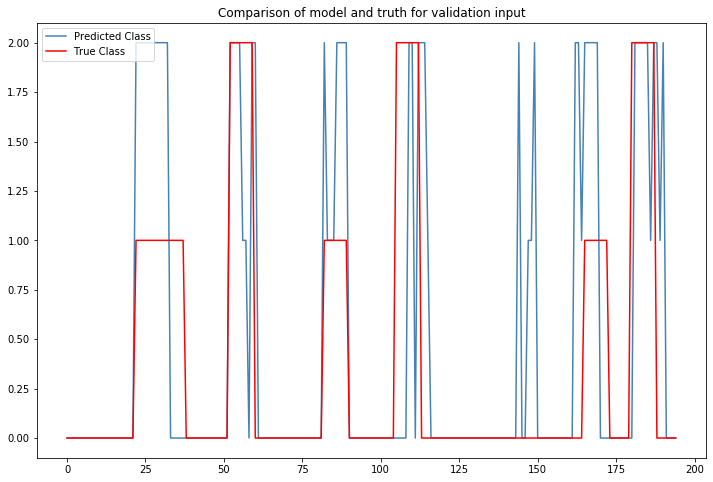

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(pred_final, color='steelblue')
ax.plot(label_final, color='red')
plt.title('Comparison of model and truth for validation input')
plt.legend(['Predicted Class','True Class'])
plt.show()

It's clear that the model is struggling to predict leaving vs entering. Overall, a good start, need more data

## Still a little bit of underfitting
- Areas for improvment
    - ~~More diverse dataset~~ (2020-04-01)
    - Hyperparameter tuning (some improvement 2020-04-04)
    - Make video window overlapping
    - ~~How to freeze some layers?~~ (2020-03-13)

In [29]:
weight_save_path=Path('/media/tris/tris_files/CSCE636-project-porta/porta.pth')
torch.save(my_model.state_dict(), weight_save_path)